# Practical Work 3 - Third experiment : Men natural vs women natural vs men synthetic vs woman synthetic

Authors : Lionel Burgbacher & David Jaquet

In [44]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

%matplotlib inline

In [45]:
PATH = './vowels/'

## Utils

In [46]:
# Read all the wav files
def read_files(files):
    readed = []
    
    for file in files:
        readed.append(wav.read(os.path.join(PATH, file)))
    
    return readed

# Generate the Mel-Frequency Cepstrum Coefficients
def generate_mfcc(files):
    mfcc_array = []
    for (rate, X) in files:
        mfcc_array.append(mfcc(X, samplerate=rate, nfft=1024))
        
    return mfcc_array

# Calculate the mean of the features for the given array
def calculate_feature_mean(mfcc):
    feature_mean = []
    
    for feature in mfcc:
        mean = np.mean(feature,axis=0)
        feature_mean.append(mean)
    return feature_mean

# Calculate the median of the features for the given array
def calculate_feature_std(mfcc):
    feature_std = []
    
    for feature in mfcc:
        deviation = np.std(feature,axis=0)
        feature_std.append(deviation)
    return feature_std

# Calculate the standard deviation of the features for the given array
def calculate_feature_median(mfcc):
    feature_median = []
    
    for feature in mfcc:
        median = np.median(feature,axis=0)
        feature_median.append(median)
    return feature_median

# Normalize data per columns between min and max
def scale(array, min, max):
    nom = (array-array.min(axis=0))*(max-min)
    denom = array.max(axis=0) - array.min(axis=0)
    denom[denom==0] = 1
    return min + nom/denom

# Sum the elements of "array" from "column" (both given in parameters)
def sumRow(array, row):
    sum = 0
    
    for i in range(len(array)):
        sum += array[row][i]
    return sum

# Sum the elements of "array" from "column" (both given in parameters)
def sumColumn(array, column):
    sum = 0
    
    for i in range(len(array)):
        sum += array[i][column]
    return sum

# Sum the elements of the diagonal from "array" given in parameters
def sumDiagonal(array):
    sum = 0
    
    for i in range(len(array)):
        sum += array[i][i]
    return sum

## Experiment

In [47]:
# src : https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
# Collect all the men files
men_files_nat = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('nam') and file.endswith('.wav'))]
men_files_syn = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('sam') and file.endswith('.wav'))]
# Collect all the women files
women_files_nat = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('naf') and file.endswith('.wav'))]
women_files_syn = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('saf') and file.endswith('.wav'))]


In [48]:
men_nat = read_files(men_files_nat)
men_syn= read_files(men_files_syn)

women_nat = read_files(women_files_nat)
women_syn = read_files(women_files_syn)

men_nat_mfcc = generate_mfcc(men_nat)
men_syn_mfcc = generate_mfcc(men_syn)
women_nat_mfcc = generate_mfcc(women_nat)
women_syn_mfcc = generate_mfcc(women_syn)

men_nat_feature = calculate_feature_median(men_nat_mfcc)
men_syn_feature = calculate_feature_median(men_syn_mfcc)
women_nat_feature = calculate_feature_median(women_nat_mfcc)
women_syn_feature = calculate_feature_median(women_syn_mfcc)

In [49]:
# Append all the datas
datas = []
MAN_NAT   = [1,-1,-1,-1]
MAN_SYN   = [-1,1,-1,-1]
WOMAN_NAT = [-1,-1,1,-1]
WOMAN_SYN = [-1,-1,-1,1]

for feature in men_nat_feature:
    datas.append(np.append(feature, MAN_NAT))
for feature in men_syn_feature:
    datas.append(np.append(feature, MAN_SYN))

for feature in women_nat_feature:
    datas.append(np.append(feature, WOMAN_NAT))
for feature in women_syn_feature:
    datas.append(np.append(feature, WOMAN_SYN))  
    
datas = scale(np.asarray(datas), -1, 1)

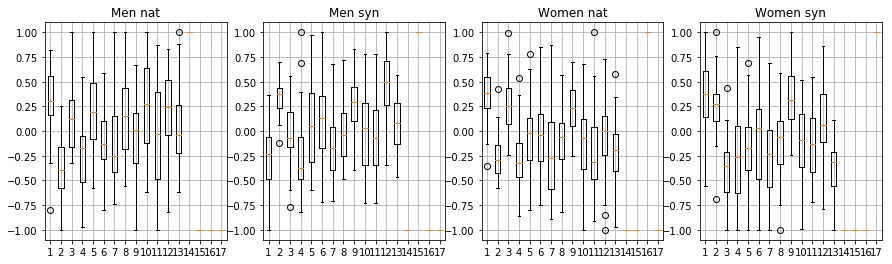

In [50]:
pl.figure(figsize=(15,4))
pl.subplot(1,4,1)
pl.boxplot(datas[:36])
pl.title('Men nat')
pl.grid()
pl.subplot(1,4,2)
pl.boxplot(datas[36:72])
pl.title('Men syn')
pl.grid()
pl.subplot(1,4,3)
pl.boxplot(datas[72:108])
pl.title('Women nat')
pl.grid()
pl.subplot(1,4,4)
pl.boxplot(datas[108:])
pl.title('Women syn')
pl.grid()

In [14]:
N_INITS = 10
EPOCHS = 1000
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

input_data = datas[:,0:13]
output_data = datas[:,13:]

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    
    # 13 features in input and 3 output to determine man or woman or child
    nn = mlp.MLP([13, h, 4], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((input_data, output_data),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


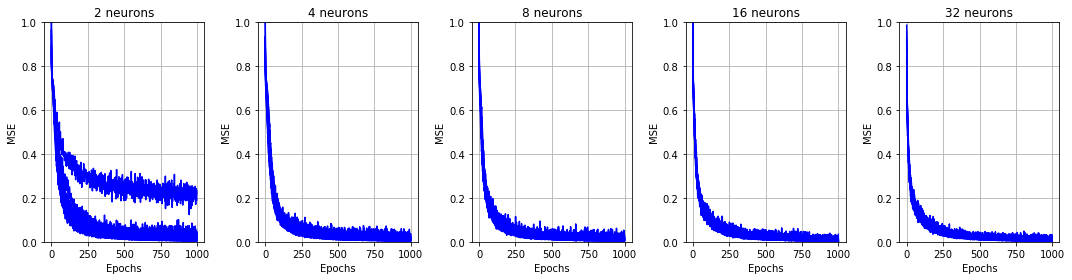

In [15]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

Dans les graphiques ci-dessus, on peut voir que le `MSE` se stabilise, quel que soit le nombre de neurones à partir de **400 epochs**. Nous avons donc de choisir cette valeur d'epochs pour la suite de l'expérience.

In [16]:
K = 5
N_TESTS = 10
EPOCHS = 600
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [17]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13, h, 4], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            datas,      # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


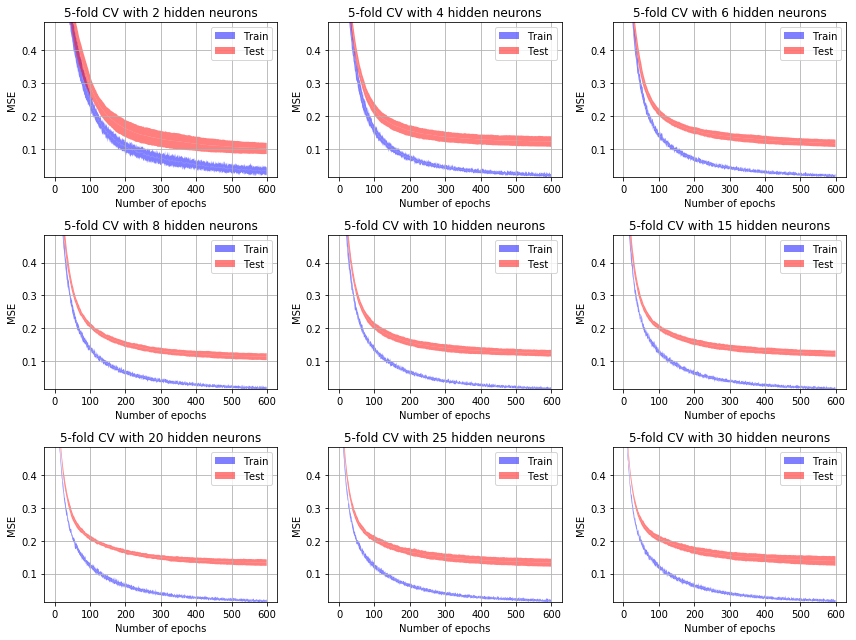

In [18]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

Les graphiques ci-dessus démontrent que les erreurs les moins fréquentes sont avec **10 et 20 neurones**.

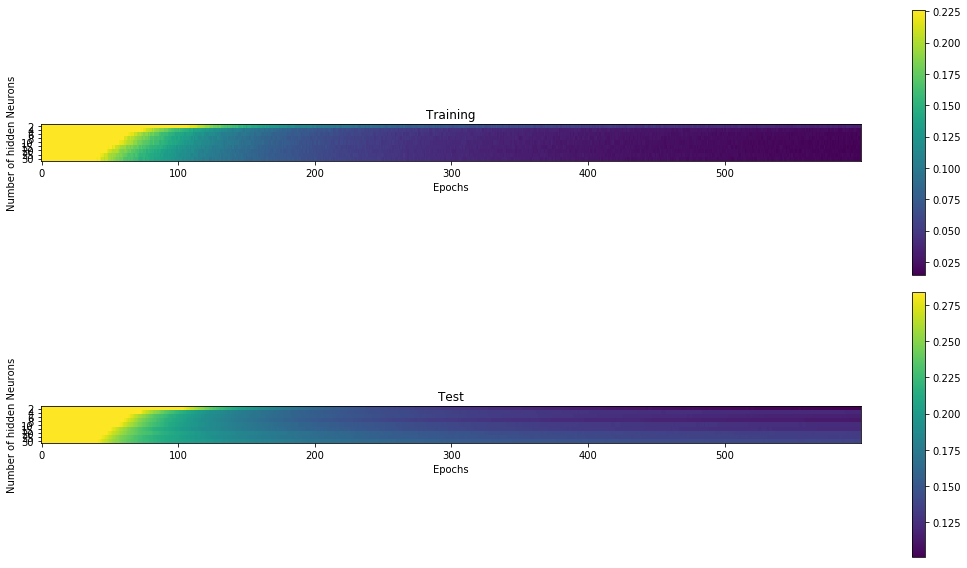

In [20]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

Selon ces graphiques, la version à 8 neurones est la meilleure. Selon nos analyses, on a décidé de prendre ces param

In [57]:
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.5
EPOCHS = 600
N_NEURONS = 8

In [58]:
nn = mlp.MLP([13, N_NEURONS, 4], 'tanh')

# Initialize to 2 to be sure they are updated
best_MSE_train = 2
best_MSE_test = 2
best_f_score = 2

# Initialize to -1 to be sure they are updated
worst_MSE_train = -1
worst_MSE_test = -1
worst_f_score = -1

best_conf_mat = np.zeros((4, 4))
total_results = np.zeros((4, 4))
worst_conf_mat = np.zeros((4, 4))

mean_MSE_train = 0
mean_MSE_test = 0

# Initialise the worst matrix to an impossible case to be sure that it is updated
for i in range(0, 4):
    worst_conf_mat[i][i] = len(men_nat_mfcc)

for i in range(0, 100):
    MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                               datas,
                                                               k=K,
                                                               learning_rate=LEARNING_RATE,
                                                               momentum=MOMENTUM,
                                                               epochs=EPOCHS,
                                                               threshold=0.0)
    if best_MSE_train > MSE_train:
        best_MSE_train = MSE_train
    elif worst_MSE_train < MSE_train:
        worst_MSE_train = MSE_train
        
    if best_MSE_test > MSE_test:
        best_MSE_test = MSE_test
    elif worst_MSE_test < MSE_test:
        worst_MSE_test = MSE_test
        
    for j in range(0, 4):
        for k in range(0, 4):
            total_results[j][k] += conf_mat[j][k]
    
    mean_MSE_train += MSE_train
    mean_MSE_test += MSE_test
       
    nb_correct = sumDiagonal(conf_mat)
    if sumDiagonal(best_conf_mat) < nb_correct:
        best_conf_mat = conf_mat
    elif sumDiagonal(worst_conf_mat) > nb_correct:
        worst_conf_mat = conf_mat

In [60]:
print("Worst MSE training: ".ljust(20, ' '), worst_MSE_train)
print("Best MSE training: ".ljust(20, ' '), best_MSE_train)
print("Mean MSE training: ".ljust(20, ' '), mean_MSE_train/100)
print("\nWorst MSE test: ".ljust(21, ' '), worst_MSE_test)
print("Best MSE test: ".ljust(20, ' '), best_MSE_test)
print("Mean MSE test: ".ljust(20, ' '), mean_MSE_test/100)
print("\nBest confusion matrix:")
print(best_conf_mat)
print("\nWorst confusion matrix:")
print(worst_conf_mat)

for i in range(0, 4):
    for j in range(0, 4):
        total_results[i][j] /= 100

print("\nMean matrix:")
print(total_results)

# src : https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2
# src : https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
# F1 Score = 2 x precision x recall / ( precision + recall)
# Natural men
man_nat_precision = total_results[0][0] / sumRow(total_results, row=0)
man_nat_recall = total_results[0][0] / sumColumn(total_results, column=0)
man_nat_f1 = 2 * man_nat_precision * man_nat_recall / (man_nat_precision + man_nat_recall)

# Synthetic men
man_syn_precision = total_results[1][1] / sumRow(total_results, row=1)
man_syn_recall = total_results[1][1] / sumColumn(total_results, column=1)
man_syn_f1 = 2 * man_syn_precision * man_syn_recall / (man_syn_precision + man_syn_recall)

# Natural women
woman_nat_precision = total_results[2][2] / sumRow(total_results, row=2)
woman_nat_recall = total_results[2][2] / sumColumn(total_results, column=2)
woman_nat_f1 = 2 * woman_nat_precision * woman_nat_recall / (woman_nat_precision + woman_nat_recall)

# Synthetic women
woman_syn_precision = total_results[3][3] / sumRow(total_results, row=3)
woman_syn_recall = total_results[3][3] / sumColumn(total_results, column=3)
woman_syn_f1 = 2 * woman_syn_precision * woman_syn_recall / (woman_syn_precision + woman_syn_recall)

print("\nMacro-precision: ".ljust(20, ' '), (man_nat_precision + man_syn_precision + woman_nat_precision + woman_syn_precision) / 4)
print("Macro-recall: ".ljust(19, ' '), (man_nat_recall + man_syn_recall + woman_nat_recall + woman_syn_recall) / 4)
print("Macro-F1: ".ljust(19, ' '), (man_nat_f1 + man_syn_f1 + woman_nat_f1 + woman_syn_f1) / 4)

Worst MSE training:  0.021706119138901452
Best MSE training:   0.013129254022098419
Mean MSE training:   0.016845488033214208

Worst MSE test:      0.1688902892206615
Best MSE test:       0.0874219188719247
Mean MSE test:       0.1222770046602814

Best confusion matrix:
[[36.  0.  2.  0.]
 [ 1. 33.  0.  2.]
 [ 3.  0. 35.  2.]
 [ 0.  1.  1. 35.]]

Worst confusion matrix:
[[32.  0.  1.  0.]
 [ 1. 32.  0.  1.]
 [ 1.  0. 31.  5.]
 [ 0.  1.  1. 33.]]

Mean matrix:
[[33.04  1.64  1.74  0.  ]
 [ 1.4  33.2   0.    1.19]
 [ 1.45  0.   33.35  1.87]
 [ 0.    0.92  1.38 33.78]]

Macro-precision:    0.9201357036046853
Macro-recall:       0.9200976676784127
Macro-F1:           0.920077502886671
